## Chapter- Segmentation Networks

## Topics 
- Introduction to dataset
- Introduction to segmentation-models repo
- Introduction to image-segmentation architecutures
- Unet Architecture 
- Convolution vs Transposed convolution
- LinkNet Architecture
- PSPNet Architecture
- FPN Architecture

## 1. Introduction to dataset 
Since cocostuffdataset is large, contains ~1.18Lakh images. Training this network would require huge compute power. It is often advisible to search for pre-trained weights for public datasets and use those networks to retrain the dataset at your hand. Here I will simplify the problem statements in two aspects. 
- Reduce the number of classes from 182 to 1 (human or no-human pixel)
- Reduce the number of train images to ~5k (contains 1-4 humans in each image) and val images to ~1k.

The dataset structure is as follows 
```
train_input_dataset: ../../data/cocostuff/images/train/*.jpg
train_target_dataset: ../../data/cocostuff/images/stuff_train/*.png
val_input_dataset: ../../data/cocostuff/images/val/*.jpg
val_target_dataset: ../../data/cocostuff/images/stuff_val/*.png
```

I  changed all the class labels in these annotations from human_pixels (1) to non_human pixels (0)

Lets train this human segmentation dataset and check weather our models can perform well in classifiing human pixels to non-human pixels.

## 2. Introduction to segmentation-models repo

In the previous section we understood various data agumentation/translation techniques and how to build dataloaders in keras.  From now on there will be less code and more theory as most of the code is already written in keras and all we need to do is call necessary functions.

To build, train and validate various segmentation models,  we will be using the segmentation-models package available via pip or github (https://github.com/qubvel/segmentation_models)

Segmentation models is python library for Neural Networks based Image Segmentation built using Keras (Tensorflow) framework.

The main features of this library are:
- High level API (just two lines to create NN).
- 4 models architectures for binary and multi class segmentation (including legendary Unet).
- 25 available backbones for each architecture.
- All backbones have imagenet pre-trained weights for faster and better convergence.

I will take a different approach in this task. Lets quickly train a neural network here by calling neccessary function and later go into the theory. The process for training the network is as follows
- call the basic Unet module with resnet34 backend
- call the bce_jaccard_loss function for loss calculation
- iou_score as the metric 
- train the model for few epochs to check the progress

Once this is done, we will go into the theory and discuss each layer. lets get started. Install **segmentation-models** package

```bash
pip install segmentation-models
```

## Quiz
Q) Which of the following are important characteristics of segmentation-models packages?  
A) Supports both binary and multi-class segmentation.  
B) Supports semantic segmentation but not instance segmentation.  
C) All the backends are available with imagenet pre-trained weights.  
D) Supports both semantic segmentation and instance segmentation.  

Ans) A, B, C . segmentation-models package is only for semantic segmentation and doesn't support instance segmentation  

## 2.1 List the train val image_ids

In [1]:
import glob
## list all the train_ids
train_ids = [i.rsplit("/")[-1].rsplit(".")[0] for  i in glob.glob("../../data/cocostuff/images/train/*.jpg")]

## list all the val_ids
val_ids = [i.rsplit("/")[-1].rsplit(".")[0] for  i in glob.glob("../../data/cocostuff/images/val/*.jpg")]

## printing the number of train_ids and val_ids
print("train_ids:{}, val_ids:{}".format(len(train_ids), len(val_ids)))

train_ids:4500, val_ids:564


## 2.2 Build train and validation dataloader.
We have already seen how to build the dataloader in previous section. lets call that function along with following parameters 

| param | value | description |
| --- | ---| ---|
| root| "../../data/cocostuff/images/" | location of the images folder. Same for both train and validation|
| folder_name| "train" | folder name of the images "val" for validation data|
| batch_size | 16 | batch_size used for training |
| resize | 512 | resize int|
| flip | True| False in validation |
| crop | 448 | crop size |
| scales | (0.9, 0.95,  1., 1.05, 1.1) | scales used|
| mean_rgb| (0, 0, 0) | values to fill channel wise for paded pixels |
| pre_process | False| described below|
| rgb | True | weather RGB image or BGR image|
| shuffle | True | weather to shuffle that data after each and every epoch or not |
| ignore_label| 0 | consider them as background pixels|
| color_transforms | True| weather to perform color transforms or not|

### pre-process
The segmentation-models has get_preprocessing function, which outputs a preprocessing func for required backend. In the next section we will see that there are 34 backends available for us to train. These backends are nothing but standard image classifier architecutures like **densenet**, **resnet** and **inceptionv3** etc. All these networks are pre-trained on imagenet using different preprocessing piplines. These pre-processing pipelines includes, normalizing (divide by 255), standardization (subtract by mean and divide by std) etc. For example, if you are using tensorflow pretrained inceptionv3, the image is divided by 127.5 and later subracted by -1 (as shown [here](https://github.com/keras-team/keras-applications/blob/dda499735da01ab6c6f029b37dbdf35cc82db136/keras_applications/imagenet_utils.py#L45)). 

To make this uniform across different architecutures, **segmentation_models** wrapped all the pre-processing functions for every architecuture in **get_preprocessing** function. we can call this as follows.

```python
from segmentation_models.backbones import get_preprocessing
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
```
This preprocess_input is sent to the dataloader. It is applied at the end of all the augumentations and resizing and before passing it to the network.

In [1]:
from segmentation_models.backbones import get_preprocessing
BACKBONE = 'resnet50'
preprocess_input = get_preprocessing(BACKBONE)

Using TensorFlow backend.
/mnt/nfshome1/FRACTAL/vanapalli.prakash/miniconda3/envs/keras/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [3]:
## Call the dataloader
from coco_dataloader import CocoStuffDataGenerator

train_datagen = CocoStuffDataGenerator(list_ids= train_ids, \
                                       root="../../data/cocostuff/images/", \
                                       folder_name = "train",\
                                       batch_size=8, \
                                       resize=512, \
                                       flip = True, \
                                       crop = 448,\
                                       scales = (0.9, 0.95,  1., 1.05, 1.1),\
                                       mean_rgb = (0, 0, 0),\
                                       pre_process = preprocess_input, \
                                       ignore_label = 0., \
                                       rgb = True, \
                                       color_transforms=True, \
                                       shuffle=True)

val_datagen = CocoStuffDataGenerator(list_ids = val_ids,\
                                     root="../../data/cocostuff/images/", \
                                     folder_name = "val",\
                                     batch_size=8, \
                                     resize=512, \
                                     flip = True, \
                                     crop = 448,\
                                     scales = (1., 1.05),\
                                     mean_rgb = (0, 0, 0),\
                                     pre_process = preprocess_input, \
                                     ignore_label = 0., \
                                     rgb = True,\
                                     color_transforms=False, \
                                     shuffle=True)

### 2.3 Visualize the input images and output images.
This is very similar to what we have done in data transformation module 5.2 section. 

In [19]:
## Read a batch of images
X, y = train_datagen[100]
print(X.shape, y.shape)

(8, 448, 448, 3) (8, 448, 448, 1)


In [8]:
from skimage.util import montage # to visualize all the images at once.
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, '$\\Delta$T Mask')

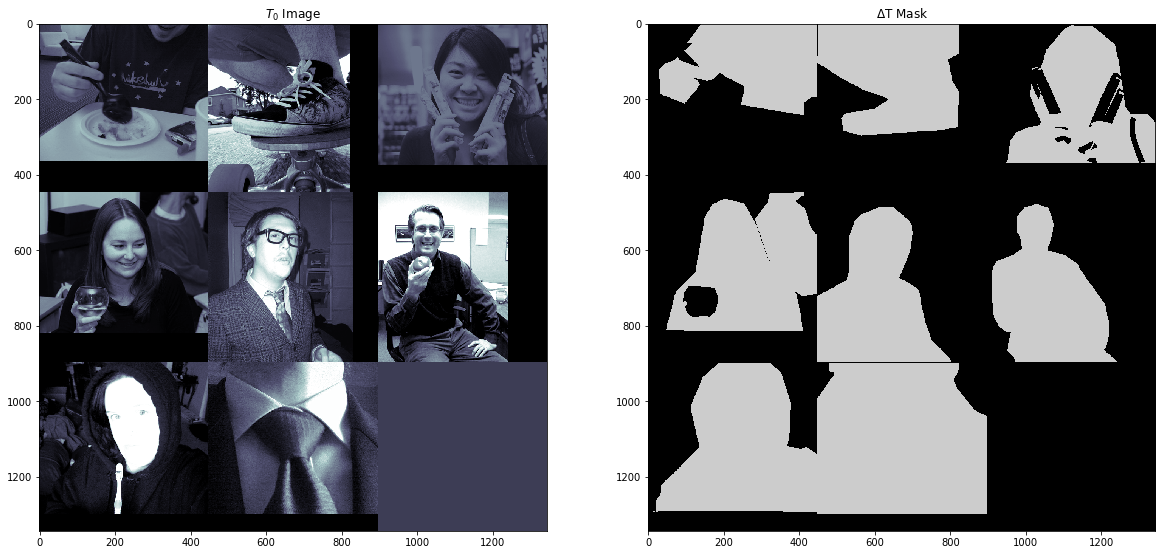

In [9]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow(montage(y[:, :, :, 0]), cmap = 'nipy_spectral')
ax3.set_title('$\Delta$T Mask')

## 2.4 Load Loss functions, metrics and network
Loss functions, metrics and networks are clearly defined in the segmentation modules functions. We will discuss about these in-detail in the comming sections.

In [10]:
## Import the loss function
from segmentation_models.losses import bce_jaccard_loss

## Import the metric
from segmentation_models.metrics import f1_score

## Import Unet
from segmentation_models import Unet

In [11]:
# define model
model = Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation="sigmoid")

## Compile the model using Adam optimizer
model.compile('Adam', loss=bce_jaccard_loss, metrics=[f1_score])

Instructions for updating:
Colocations handled automatically by placer.


## 2.5 Train the network for 10 epochs 

In [12]:
## Training it for 10 epochs
model.fit_generator(generator= train_datagen,
                    validation_data= val_datagen,
                    use_multiprocessing= True,
                    workers= 6, 
                    epochs= 10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
562/562 [==============================] - 252s 448ms/step - loss: 0.7718 - score: 0.7672 - val_loss: 0.9118 - val_score: 0.7843
Epoch 2/10
562/562 [==============================] - 239s 426ms/step - loss: 0.6320 - score: 0.8168 - val_loss: 0.8527 - val_score: 0.7964
Epoch 3/10
562/562 [==============================] - 239s 425ms/step - loss: 0.5829 - score: 0.8323 - val_loss: 0.6436 - val_score: 0.8072
Epoch 4/10
562/562 [==============================] - 239s 424ms/step - loss: 0.5789 - score: 0.8341 - val_loss: 0.8094 - val_score: 0.7861
Epoch 5/10
562/562 [==============================] - 239s 426ms/step - loss: 0.5436 - score: 0.8454 - val_loss: 0.7178 - val_score: 0.8209
Epoch 6/10
562/562 [==============================] - 240s 427ms/step - loss: 0.5249 - score: 0.8515 - val_loss: 0.5431 - val_score: 0.8532
Epoch 7/10
562/562 [==============================] - 239s 425ms/step - loss: 0.5214 - score: 0.8523 - val_loss:

We got val **f1_score** of 0.8558 at 6th epoch. lets save this model state and use it for calculating other metrics in the next section

In [18]:
model.save_weights("../../data/cocostuff/model.h5")
print("Model saved")

Model saved


## 2.6 Predict on a batch of images 
To visually check how our model is working, lets predict on a batch of images. I have used 0.5 as threshold. we can change the threshold depending on tuning for precision or recall.

In [13]:
import numpy as np
import cv2
x = model.predict_on_batch(X)
x = np.where(x > 0.5, 1, 0) ## Using 0.5 as threshold
x.shape

(8, 448, 448, 1)

Text(0.5, 1.0, '$\\Delta$T Mask')

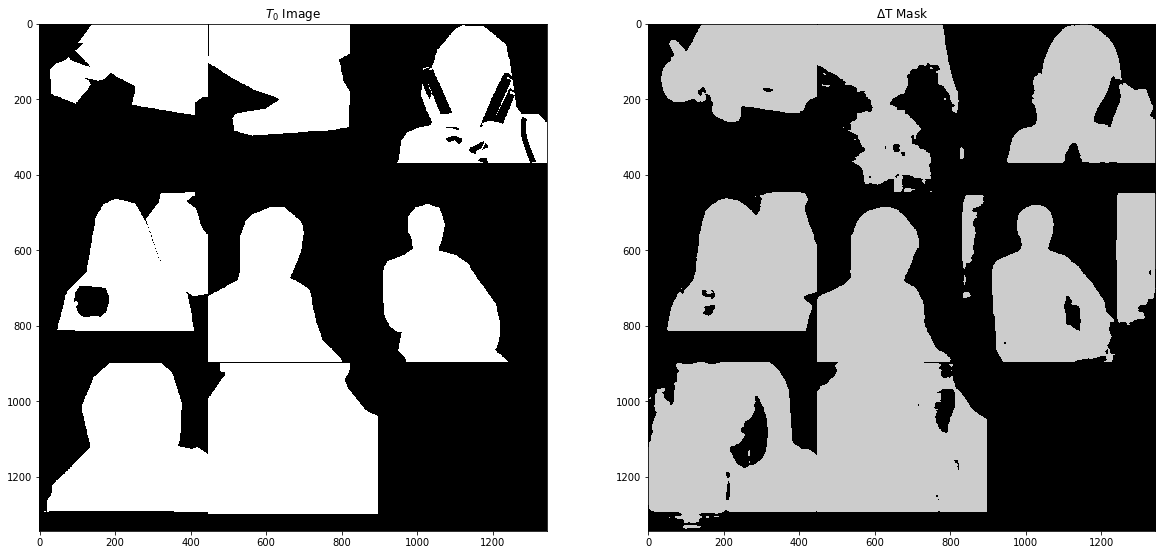

In [17]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(y[:, :, :, 0]), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow(montage(x[:, :, :, 0]), cmap = 'nipy_spectral')
ax3.set_title('$\Delta$T Mask')

## Quiz
How does the input image is transformed using **get_preprocessing** when the backbone is "resnet34".  
A) lambda x- 127.5: x  
B) x / 127.5 and later subtracted by -1   
C) x / 255.0  
D) lambda x: x  

Ans) D. Use ??get_preprocessing(BACKBONE) to findout what is happening

Now since we have seen how the segmentation models are trained using **segmentation_models** repo, we will try understand how these are architecutures are defined. 

## 3. Introduction to image-segmentation architecutures

The segmentation module contains 4 architecutures.
- Unet
- FPN
- Linknet
- PSPNet

It is available with the following backends.
**Backbones**

|Type | Names |
|-------| -----------|
|VGG |         ``'vgg16' 'vgg19'``
|ResNet|       ``'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152'``
|SE-ResNet|    ``'seresnet18' 'seresnet34' 'seresnet50' 'seresnet101' 'seresnet152'``
|ResNeXt | ``'resnext50' 'resnet101'``
|SE-ResNeXt|   ``'seresnext50' 'seresnet101'``
|SENet154 |    ``'senet154'``
|DenseNet |    ``'densenet121' 'densenet169' 'densenet201'`` 
|Inception |   ``'inceptionv3' 'inceptionresnetv2'``
|MobileNet |   ``'mobilenet' 'mobilenetv2'``

 -  All backbones have weights trained on 2012 ILSVRC ImageNet dataset (``encoder_weights='imagenet'``). 
 - Intotal there are 24 backends and 4 different architecuture types. Combaining all of these we have 96 architecuture models. Now lets look at each of these architecutures using **resnet18** as backend.
 
 
## 3.1 How segmentation networks are designed ?
People who have gone through the image classification classes might have observed the following aspects . Every image goes through a series of convolution and pooling layers depending upon the architectures mentioned above and finally we have fully connected layer which classifies the objects present in it. The high level features mentioned below in the diagram are called **Encoded features**. These are useful representation of features in the 2048 dim vector. Since we have encoded the image from 224 x 224 x 3 to 2048 useful feature vector we call this an **Encoder network**. The attached Fully connected layer is a classification layer classifing different objects (1000 here because of imagenet). 


![Image classifier diagram](../images/image_classifer.png)

In image segmentation, We use these standard image classification encoders and attach a decoder to it. Decoders are nothing but a set of convolutional and upsampling layers which will increase the feature map size gradually and brings it to the image size classifing each pixel into a class. Different network architecutures use different types of decoders. This lesson is dedicated to understanding these decoders. 

![Encoder_decoder diagram](../images/encoder_decoder.png)



## Quiz

Q) Which the following backends are not available in segmentation-models? (one or more right answers)  
A) dpn68  
B) inceptionv4  
c) seresnet18  
d) resnet18  


Ans) A, B .DualPathNetworks (DPN) and Inceptionv4 is not implemented in segmentation-models repo?

# 4 UNet 
Unet was first introduced by Olaf Ronneberger, Philipp Fisher and Thomas Brox for Biomedical Image segmentation in 2015. The authors won the ISBI cell tracking challenge where they need to segment neuronal structures in electron microscopic tasks. 

Some of its features include:
- UNet uses the full image for segmentation. It takes an input as image and output a mask of the same size as input image.
- It consists of a contracting (encoder, left side) path and an expansive (decoder, right side). 
- The contracting path follows the typical architecture of a convolutional network. Here in this example we have used ResNet as an example. Inspite of the depth, there are 4 resblocks. To know more about resnet architecture (https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624).

![UNet architecture](../images/unet_seg.png)
- As shown in the above diagram, In each resblock we double the number of feature channels and reduce the size of feature map size by half.
- For increasing the size of feature map in decoder, we can use upsampling or convTranspose. In the diagram below we have used upsampling. convTranspose working is explained in the next section, For now remember that it upscale the feature maps . The default in Unet function uses upsampling, we can use **transpose** for decoder_block_type to use convTranspose. Note that this is a hyperparameter which you can use and test.
- Below are the parameters of UNet available. 

| Arguments | Default | Description |
| ----------------|------------| -----------------|
| backbone_name| "vgg16"| The type of decoder we want to use. We can use any of the 24 architecutures I noted above|
| input_shape| (None, None, 3) | By default it takes only 3 channel input image of any size. If you are mentioning the size, we need to match it with DataGenerator output size|
| activation| "sgmoid" | If it is 1 class use sigmoid, if it has multiple classes use "softmax"|
| encoder_weights| "imagenet" | By default it uses imagenet weights, we can keep None if we don't want to use imagenet weights, it will be randomly initialization in that case.|
| encode_freeze | False |  If True, the encoder weights are freezed and the weights will not be trained.|
| decoder_block_type| "upsampling" | We can either use "upsampling" or "transpose" (conv2dTranspose is used)|
| decoder_filters| (256, 128, 54, 16) | This goes in line with the type of encoder used.|
| decoder_use_batchnorm| True | whether to use batchnorm or not in decoder block|

The below code allows you to call Unet architecture using **segmentation_models** repo
```python
# define model
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

BACKBONE= "resnet18"
preprocess = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet', input_shape=(448, 448, 3))
```

## Task
- Build a Unet model using the following params 
    - backbone_name='seresnet18',
    - input_shape=(448, 448, 3),
    - classes=10,
    - activation='softmax',
    - encoder_weights=None,
    - encoder_freeze=False,
    - encoder_features='default',
    - decoder_block_type='upsampling',
    - decoder_filters=(256, 128, 64, 32, 16),
    - decoder_use_batchnorm=True,

(a) the objective of performing the task  i.e. what will the learner perform and gain out of that task,   
Use segmentation-models repo and build a basic Unet model with required params.
 
(b) a set of instructions
- Call Unet module using the above described params

(c) the solution code. 

```python
BACKBONE= "seresnet18"
model = Unet(BACKBONE, 
             input_shape=(448, 448, 3),
             classes = 10, 
             activation="softmax",
             encoder_weights=None,
             encoder_freeze= False, 
             encoder_features="default", 
             decoder_block_type='upsampling',
             decoder_filters=(256, 128, 64, 32, 16), 
             decoder_use_batchnorm=True)
print(model.summary())
```

## Topic-3 Convolution vs Transposed Convolution
In the decoder section (right of unet diagram), we have observed that feature map size increases from 32-64-128-256-512 (input_image_size). There are two ways to upsample a image( or feature map). 
- Predefined interpolation methods like [Bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation).
- train a network to learn upsample optimally using **Transposed convolution**

The Bilinear interpolation doesn't have any parameters to train and is a linear interpolation of cells across it. Read the wikipedia blog to understand it further. In this section we will focus on **Transposed convolution**. the transposed convolution is also known as **Fractionally-strided convolution** and **Deconvolution**. Lets understand how convolution is performed in libraries like keras and how it is repurposed to obtained transposed convolution.

### Convolution Operation
Let’s use a simple example to explain how convolution operation works. Suppose we have a 4x4 matrix and apply a convolution operation on it with a 3x3 kernel, with no padding, and with a stride of 1. As shown below, the output is a 2x2 matrix.

![conv operation](../images/ct1.png)

The convolution operation calculates the sum of the element-wise multiplication between the input matrix and kernel matrix. Since we have no padding and the stride of 1, we can do this only 4 times. Hence, the output matrix is 2x2.

![conv operation on excel](../images/ct2.png)

One important point of such convolution operation is that the positional connectivity exists between the input values and the output values. For example, the top left values in the input matrix affect the top left value of the output matrix.More concretely, the 3x3 kernel is used to connect the 9 values in the input matrix to 1 value in the output matrix. **A convolution operation forms a many-to-one relationship**. Let’s keep this in mind as we need it later on.

### Going Backward

Now, suppose we want to go the other direction. We want to associate 1 value in a matrix to 9 values in another matrix. It’s a **one-to-many relationship**. This is like going backward of convolution operation, and it is the core idea of transposed convolution.

For example, we up-sample a 2x2 matrix to a 4x4 matrix. The operation maintains the 1-to-9 relationship.

![conv reverse operation on excel](../images/ct3.png)

But how do we perform such operation? To talk about how, we need to define the convolution matrix and the transposed convolution matrix.

### Convolution Matrix

We can express a convolution operation using a matrix. It is nothing but a kernel matrix rearranged so that we can use a matrix multiplication to conduct convolution operations.Each row of a convolution matrix is just a rearranged kernel matrix with zero padding in different places.

![kernel matrix rearranged](../images/ct_4_5.png)

Now since the input matrix is (4x4) and the kernel matrix is (4x16), if we rearrage the input matrix to (16x1). Then the dot product of both the input matrix and the kernel matrix would give output as (4x1), which again can be resized as (2x2). This is the way convolution operations happen inside the libraries like keras. Below is the diagram which helps the process.

![matrix operation](../images/c6_7_8.png)


### Transposed convolution matrix 

We want to go from 4 (2x2) to 16 (4x4) (this is similar to the way in UNet we went from 32 x32 feature map to 64x64 feature map in the decoder block).  So we need to use a 16x4 matrix. One way to obtain this is to transpose the kernel matrix we defined previously (C =4x16 to C.T =16x4) and multiply it with column vector 4x1 to generate an output matrix 16x1. The transposed matrix connects 1 value to 9 values in the output. Finally we can reshape the 16x1 matrix to 4x4.

![transposed convolution matrix](../images/ct9_10.png)


We have just up-sampled a smaller matrix (2x2) into a larger one (4x4). The transposed convolution maintains the 1 to 9 relationship because of the way it lays out the weights. Please note that the values in the kernel for convolution (4x16) and for transpose convolution (16x4) will not be the same when you train the network. Here I showed it for interpretion purpose only.

The transposed convolution operation forms the same connectivity as the normal convolution but in the backward direction. We can use it to conduct up-sampling. Moreover, the weights in the transposed convolutoon are learnable. So we do not need a predefined interpolation method.



## Quiz  

Q) Which of the following is True ?  
A) A network with upsampling layers have more params than convtranspose layers (considering all other things are same).  
B) A network with upsampling layers have less params than convtranspose layers (considering all other things are same).  
C) The network has the same number of params irresepective of convtranspose or upsampling layer (considering all other things are same).  
D) The number of params more or less depends on the network used.  

Ans) A . Upsampling layer uses bilinear interpolation and doesn't have any params compared to convtranspose, which is a convolution layer and contains params.

## Topic-5 LinkNet
- LinkNet is a full image segmentation Network designed for efficency and speed.
- compared to UNet discussed above which has 14.3 million parameters we have only 11.17 million parameters. 
- The author hypothesis is that while pooling a lot of local information is lost and adding input of each stage in encoder to the output of each stage to decoder will recover some lost information. So every input of Encoder is added to the output of Decoder as shown in the figure . Note that they have added the values as link in ResNet like structure rather than concatenate it (Like in the way it is done in UNet). Since the number of feature maps reduces because of addition, the authors claim to be more efficient.
- Each Decoder block contains 1 x 1 conv layer followed by upsampling layer (conv2dTranspose or upsample) , 3x3 conv and a 1x1 conv layer. The initial conv layer reduces the number of feature maps by 4 (512 feature maps of the last decoder block is reduced to 128 features maps in the first decoder block) and the final conv layer increases it by 2 (Except for the last block), this overall decreases the number of feature maps by 2. 
- Similarly, the feature map size in each encoder block is decreased from 512-256-128-64-32-16 and again increased from 16-32-128-256-512(input_size) in the decoder block.
- The Author validates this network by running various tests on cityscapes datasets and compares it with other architecutures. Due to its resnet like structure across skip-connections, other networks with even deeper encoders like VGG19 or ResNet101 underperformed compared to LinkNet with resnet18 backend. 
![Linknet](../images/linknet_seg.png)
- Below are some important parameters used in LinkNet. 

| Arguments | Default | Description |
| ----------------|------------| -----------------|
| backbone_name| "vgg16"| The type of decoder we want to use. We can use any of the 24 architecutures I noted above|
| input_shape| (None, None, 3) | By default it takes only 3 channel input image of any size. If you are mentioning the size, we need to match it with DataGenerator output size|
| activation| "sigmoid" | If it is 1 class use sigmoid, if it has multiple classes use "softmax", use "linear" incase if you want to use your own function|
| encoder_weights| "imagenet" | By default it uses imagenet weights, we can keep None if we don't want to use imagenet weights, it will be randomly initialization in that case.|
| encode_freeze | False |  If True, the encoder weights are freezed and the weights will not be trained.|
| decoder_block_type| "upsampling" | We can either use "upsampling" or "transpose" (conv2dTranspose is used)|
| decoder_filters| (None, None, None, None, 16) | for block with skip connection a number of filters is equal to number of filters in corresponding encoder block|
| decoder_use_batchnorm| True | whether to use batchnorm or not in decoder block|

```python
from segmentation_models import Linknet
from segmentation_models.backbones import get_preprocessing

BACKBONE= "resnet18"
preprocess = get_preprocessing(BACKBONE)
model = Linknet(BACKBONE, encoder_weights='imagenet', input_shape=(512, 512, 3))
```

## Quiz 
Q) Which of the following is true about linknet ?  
A) For same backend, Unet has comparitevly less number of params compared to linknet.  
B) For same backend, linknet has comparitevly less number of params compared to Unet.  
C) In Linknet, skip connections does element wise addition instead of stacking of feature maps.  
D) In linknet, skip connections stack feature maps instead of element wise addition.  


Ans) B, C . From the diagram we can see that (+) is present after every decoder block, which means element wise addition. Due to element-wise addition instead of stacking (as done in Unet), the number of params are relatively less.

## Quiz:
Q) Which of the following network has the most number of Trainable params ? Use input_shape of (512, 512, 3) and encoder_weights=None for all the networks.  
A) Linknet with "resnet18" and decoder_block_type as "transpose".   
B) Linknet with "seresnet18" and decoder_block_type as "transpose".   
C) Linknet with "seresnet18" and decoder_block_type as "upsamling".  
D) Linknet with "resnet18" and decoder_block_type as "upsampling".  


Ans) B.
A) Trainable params: 11,511,924
B) Trainable params: 11,601,004
C) Trainable params: 11,600,748
D) Trainable params: 11,511,668

## Topic-5 Pyramid Scene Parsing Network (PSPNet)
- This network came 1st in ImageNet scene parsing challenge 2016, PASCAL VOC 2012 benchmark, CityScapes benchmark.
- A single PSPNet yields the new record of mIoU accuracy of 85.4% on Pascal VOC 2012 and accuracy of 80.2% on Cityscapes 
- One of the problems with fully convolutional networks is that it doesn't have global context of the images.  For example in PSPNet paper they show that a boat on the river is being predicted as car, The author hypothesis that this is because the network doesn't look at the global perspective of the image. Inorder to solve this this paper launches **Pyramid Pooling Module (PPM)** (shown in the graph below). 
- We have resnet as an encoder which is defined by downsampling rate. In the below diagram we used a downsampling rate of 8, so whereever the feature map size is 8 times smaller than the input size, we will stop there. In the diagram we used a (480, 480) input image which at stage-3 of ResNet block is (60, 60) with 128 filter maps. These are fed to PPM block.
- The PPM module fuses features under four different pyramid scales. we have 4 feature pooling layers which brings down the size from (60 x 60) to  (1, 1), (2, 2), (3, 3), (6, 6). Each pooling layer is followed by a 1 x 1 Conv block which expands the feature maps from 128 to 512. This followed by a resizing each of the feature map to (60 x 60) again using bilinear interpolation.
-  We concatenate the prior with the original feature map in the final part, where the filter maps increase to 2176.
- Concatenation is followed by 1 x 1 conv layer to reduce the filter maps to 512, further  1 x  1 conv reduces the filter maps to number of classes maintaining (60 x 60) feature map size. 
- The featue map is resized using bilinear interpolation to 480 x 480 and we apply sigmoid or softmax at the final stage. 


![PSPNet](../images/pspnet_seg.png)


Now lets look at the various parameters and how it effected the accuracy 


| Arguments | Default | Description |
| ----------------|------------| -----------------|
| backbone_name| "vgg16"| The type of decoder we want to use. We can use any of the 24 architecutures I noted above|
| input_shape| (384, 384, 3) | By default it takes only 3 channel input image of any size. If you are mentioning the size, we need to match it with DataGenerator output size. There is a shape guard to this parameter which makes sure that h, w of the input shape is divisible by (downsample_factor * 6)|
| activation| "softmax" | If it is 1 class use sigmoid, if it has multiple classes use "softmax", use "linear" incase if you want to use your own function. Compared to other nets, where the nets have "sigmoid" as output this net has output as "softmax"|
| classses| 21 | The number of classes. |
| encoder_weights| "imagenet" | By default it uses imagenet weights, we can keep None if we don't want to use imagenet weights, it will be randomly initialization in that case.|
| encode_freeze | False |  If True, the encoder weights are freezed and the weights will not be trained.|
| downsample_factor| 8 | Where to stop the decoder|
| psp_conv_filters| 512 | How many filters to use in the PSP block conv layer|
| psp_pooling_type| "avg" | whether to use "avg" pooling or "max" pooling|
| psp_dropout| None | Whether to use dropout or not. This is not shown in our diagram but after concatenation we can add a dropout layer and drop some of the filters to avoid over fitting|
| final_interpolation| "bilinear"| Default is "bilinear" but we can use "duc" also which applies conv block and reshapes the outputs of it to image_size|

The authors of this paper have added several ablations studies in this paper. I will mention a few below so that it helps you in hyper parameter tuning 
- The authors emperically found that Avg pooling performed better than Max pooling 
- The authors emperically found that PSP module with 4 layers (1, 2, 3, 6) is better than 1 layer (1).
-  The performance improved by adding 1x1 conv block to reduce the dimension of the features. 
- with network depth increasing (resnet18, resnet50, resnet152, resnet269) the performance increased.
- Multi-scale testing and Data agumentation improves the perfomance of the network further. 

Go through the paper https://arxiv.org/pdf/1612.01105.pdf for better understanding 

In [ ]:
from segmentation_models import PSPNet
BACKBONE= "resnet34"
model = PSPNet(BACKBONE, encoder_weights='imagenet', input_shape=(528, 528, 3), num_classes=1, activation="sigmoid")

## Quiz
Q) Which of the following claims of the authors were true when testing PSPnet? (One or more correct answers)  
A) Avg pooling performed better than max pooling.  
B) PSP module with 1 layer performed better than with 4 layers (1, 2, 3, 6).  
C) with depth (resnet18, resnet50, resnet152, resnet269) the network performance decreased.  
D) with depth (resnet18, resnet50, resnet152, resnet269) the network performance increased.  

Ans) A and D.

## Topic-6 FPN
- **Feature Pyramid networks (FPN)** launched by Kaiming He and team has improved the object detection accuracy a lot. All the frameworks introduced till then like Faster RCNN, Mask-RCNN, RetinaNet were upgraded with FPN layers and saw increased performance. 
- Having a unified framework (Network) for object detection, instance segmentation and semantic segmentation would be of great help as this would make your network selection simple and spend your time in tuning other parameters instead of selecting/designing networks. 
- before the invention of FPN researchers while submitting results to the Imagenet and other challenges used to use multi-scale approach to improve their accuracies. For example, We resize an image into various sizes (in the form of image pyramid) and send each image to the network and later aggreagate the results. Their hypothesis is that small image will capture small objects and larger images will capture large objects and can be proved by the results obtained. One of the problems with this is that the train and test are evaluated differently and sending multiple images to the network is time consuming.
- The author came out with this network called FPN where instead of image pyramids, take features after each resblock and use them in the pyramid form. Thus feature pyramid network. 
- Each Pyramid has different feature map size and channels. The earlier layers have better localization features and later layers have rich semantic features, combining these will lead to a rich semantic with better localization features. This leads to having both global context and local context.
- Each resblock output is attached to a (1 x 1) conv block to bring the filter maps to 256.
- The network follows a top-down approach where the features of the top layer are resized to one layer before that and added to it in the form of skip connections followed by resnet architecuture. 
- Each top-down layer is then attached two 3 x 3 conv layers which brings down the filter maps to 128 keeping the size of feature maps the same.
- All the segmentation layers are resized to 128 x 128 using tensorflow Resize bilinear option and later concatenated increasing the filter maps to 512 (128 x four layers)
- A 3x3 conv layer followed by another 3x3 conv layer to reduce the number of filter maps to num_classes. This is followed by a resize layer which resizes the image to input size. The last activation layer is applied (sigmoid for one class and softmax if number of classes greater than 1).  

![FPN](../images/fpn_seg.png)

- More information go through this link http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf

In [27]:
from segmentation_models import FPN
BACKBONE= "resnet34"
model = FPN(BACKBONE, encoder_weights='imagenet', input_shape=(512, 512, 3), num_classes=1, activation="sigmoid")

## Task
- Build a FPN network with resnet50 as backend, encoder_weights as None,  num_classes as 100, activation as "softmax" and input size as (512, 512, 3), 
- using from **keras.utils.vis_utils.plot_model** plot the model, write the image to model.png, use show_layer_names=True, show_shapes=True as params.
- using PIL view the diagram

Note: we need [graphviz](http://www.graphviz.org/) library to solve this task.

(a) the objective of performing the task i.e. what will the learner perform and gain out of that task, 
To build FPN using segmentation-models repo

(b) a set of instructions and 
- Call FPN function using the required params.
- Use plot_model function in keras.utils.vis_utils to draw the network and save it to a file (model.png)

(c) the solution code. 
```python
from keras.utils.vis_utils import plot_model

BACKBONE = "seresnet18"
model = FPN(BACKBONE, encoder_weights=None, input_shape=(512, 512, 3), num_classes=1, activation="sigmoid")

## plot the network
plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

## view the network
from PIL import Image
Image.open("model.png")
```

## Reference for this section
- Medium blog post on Upsampling [link](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
- A guide to convolution arthematic for deep learning [link](https://arxiv.org/abs/1603.07285)
- FPN for segmentation from FAIR. [link]( http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf)
- PSPNet [link](https://arxiv.org/pdf/1612.01105.pdf)
- LinkNet [link](https://arxiv.org/abs/1707.03718?context=cs.LG)
- Unet [link](https://arxiv.org/abs/1505.04597)
- ResNet [link](https://arxiv.org/abs/1512.03385)